In [1]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from skimage import io # 

/home/jay/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
# Parameters
n_iters = 100
n_predict = 72
batch_size = 10
lr = 0.001  # learning_rate

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [4]:
class TrainSet(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        
    def __len__(self):
        return 650
    
    def __getitem__(self, index):
        index += 1
        if index <= 400-36:
            img_name = 'images/DX/Noisy/' + str(index) + '.pgm'
            label_name = 'images/DX/Original/' + str(index) + '.pgm'
        else:
            img_name = 'images/MMM/Noisy/mdb' + str(index+36) + '.pgm'
            label_name = 'images/MMM/Original/mdb' + str(index+36) + '.pgm'
        image = io.imread(img_name)
        label = io.imread(label_name)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

In [5]:
class TestSet(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        
    def __len__(self):
        return 72
    
    def __getitem__(self, index):
        index += 1
        if index <= 36:
            img_name = 'images/DX/Noisy/' + str(index+400-36) + '.pgm'
            label_name = 'images/DX/Original/' + str(index+400-36) + '.pgm'
        else:
            img_name = 'images/MMM/Noisy/mdb' + str(index+650) + '.pgm'
            label_name = 'images/MMM/Original/mdb' + str(index+650) + '.pgm'
        image = io.imread(img_name)
        label = io.imread(label_name)

        if self.transform:
            image = self.transform(image)
            label = self.transform(label)
            
        return image, label

In [6]:
trainset = TrainSet(transform=transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

testset = TestSet(transform=transform)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [7]:
from torch import nn
from torch.nn import functional as F


net = nn.Sequential(
    nn.Conv2d(1, 64, 5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, 5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 64, 5, padding=2),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(64, 64, 5, padding=2),
    nn.ReLU(),
    nn.Upsample(scale_factor=2),
    nn.Conv2d(64, 1, 5, padding=2),
    )

print(net)

Sequential(
  (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (7): ReLU()
  (8): Upsample(scale_factor=2.0, mode=nearest)
  (9): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (10): ReLU()
  (11): Upsample(scale_factor=2.0, mode=nearest)
  (12): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
)


In [3]:
from torch import nn
from torch.nn import functional as F

def encode_block(in_f, out_f):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, 5, padding=2),
        nn.MaxPool2d(2),
        nn.ReLU()
    )

def decode_block(in_f, out_f):
    return nn.Sequential(
        nn.Conv2d(in_f, out_f, 5, padding=2),
        nn.ReLU(),
        nn.Upsample(scale_factor=2)
    )

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            encode_block(1, 64),
            encode_block(64, 64)
        )
        
        self.decoder = nn.Sequential(
            decode_block(64, 64),
            decode_block(64, 64),
            nn.Conv2d(64, 1, 5, padding=2),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
net = Net()

print(net)

Net(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (2): ReLU()
    )
  )
  (decoder): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Upsample(scale_factor=2.0, mode=nearest)
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (1): ReLU()
      (2): Upsample(scale_factor=2.0, mode=nearest)
    )
    (2): Conv2d(64, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)


In [8]:
from torch import optim

criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=lr)

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [12]:
net.to(device)


for epoch in range(100):  # loop over the dataset multiple times
    
    running_loss = 0.0
    for i, data in enumerate(trainloader):
        # get the inputs
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        #print statistics
        running_loss += loss.item()
        
    print('[%d, %5d] loss: %.10f' %
          (epoch + 1, i + 1, running_loss / 722))
    running_loss = 0.0

print('Finising Training')

[1,    65] loss: 0.0006537653
[2,    65] loss: 0.0006140036
[3,    65] loss: 0.0006012287
[4,    65] loss: 0.0005895894
[5,    65] loss: 0.0005794781
[6,    65] loss: 0.0006229517
[7,    65] loss: 0.0006215998
[8,    65] loss: 0.0005901634
[9,    65] loss: 0.0006161559
[10,    65] loss: 0.0005501339
[11,    65] loss: 0.0005524843
[12,    65] loss: 0.0007164319
[13,    65] loss: 0.0005256321
[14,    65] loss: 0.0005434492
[15,    65] loss: 0.0005139169
[16,    65] loss: 0.0005055283
[17,    65] loss: 0.0005113664
[18,    65] loss: 0.0005505935
[19,    65] loss: 0.0005254380
[20,    65] loss: 0.0004855239
[21,    65] loss: 0.0004890885
[22,    65] loss: 0.0004809913
[23,    65] loss: 0.0005765392
[24,    65] loss: 0.0005609146
[25,    65] loss: 0.0004665928
[26,    65] loss: 0.0004647142
[27,    65] loss: 0.0004669899
[28,    65] loss: 0.0005743450
[29,    65] loss: 0.0004947265
[30,    65] loss: 0.0004491199
[31,    65] loss: 0.0004653397
[32,    65] loss: 0.0004525802
[33,    65] loss:

torch.Size([10, 1, 64, 64])


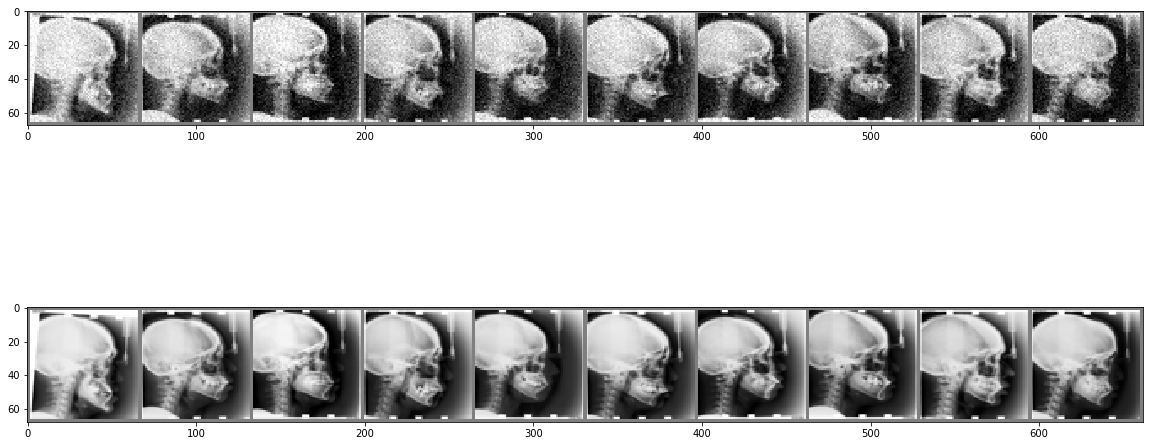

In [27]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
from torchvision.utils import make_grid

# functions to show an image

def sample_show(images, labels):
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20, 10))
    image = make_grid(images, nrow=batch_size)
    label = make_grid(labels, nrow=batch_size)
    image = image / 2 + 0.5     # unnormalize
    label = label / 2 + 0.5     # unnormalize
    npimage = image.numpy()
    nplabel = label.numpy()
    ax[0].imshow(np.transpose(npimage, (1, 2, 0)))
    ax[1].imshow(np.transpose(nplabel, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
print(images.shape)
sample_show(images, labels)

torch.Size([10, 1, 64, 64])


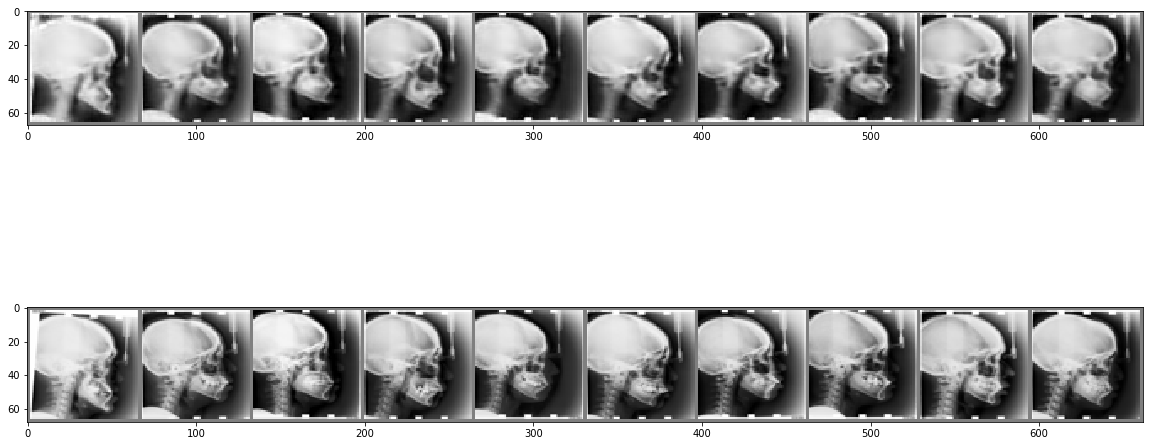

In [28]:
with torch.no_grad():
    outputs = torch.clamp(net(images.to(device)).cpu(), min=-1, max=+1)
    print(outputs.shape)
sample_show(outputs, labels)